In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 2
augment = 8

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(4)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 2000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:1' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': 1.,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=2_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'],
                    augment=augment)
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9994897959183673, 'loss': 1.0842371189275462e-05, 'std': 0.0005102040816326592, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9994897959183673, 'loss': 7.569213093965189e-06, 'std': 0.0005102040816326592, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 6.183868397388334e-06, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 5.9020360644155975e-06, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 5.4179109011261544e-06, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
losses=tensor([[1.6785e-04, 6.6299e-05, 1.2069e+01, 1.1066e+01]])
Elapsed time(grad):143.399
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):571.59
Fai

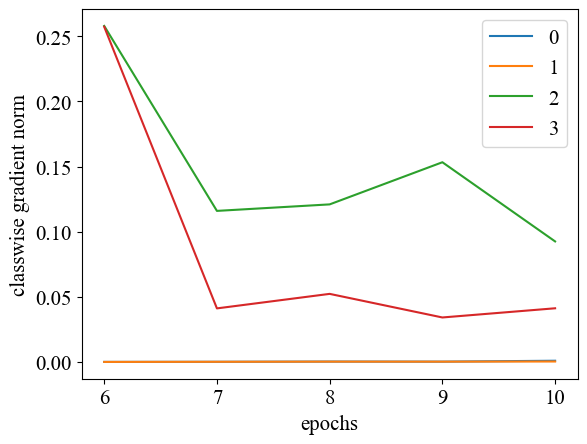

---------------------------- Task 3 -----------------------
losses=tensor([[4.1268e-04, 8.2342e-04, 1.3916e-01, 6.5631e-01, 1.2337e+01, 1.3426e+01]])
Elapsed time(grad):103.746
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):576.399
Fairness:[ 0.          0.08445493  0.         -0.11101398  0.01327965  0.01327948]
len(updated_seq_indices)=28736
Elapsed time(etc):0.454
[11] Eval metrics for task 1 >> {'accuracy': 0.9303380382990201, 'loss': 0.0009522940391062563, 'std': 0.03441967095208126, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8475813569729066, 'loss': 0.0027290213703525406, 'std': 0.03459686084887559, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.932128081247203, 'loss': 0.0008091574918434994, 'std': 0.057688619363794935, 'EER': -1}
losses=tensor([[0.0012, 0.0013, 0.0011, 0.0015, 0.0668, 0.3143]])
Elapsed time(grad):100.898
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):545.936
Fairness:[ 0.      

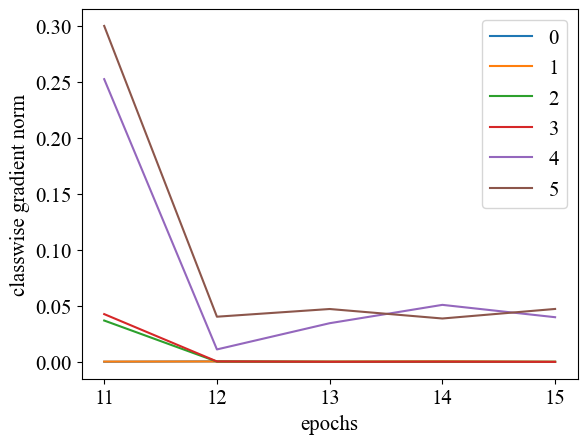

---------------------------- Task 4 -----------------------
losses=tensor([[1.7251e-04, 3.5636e-04, 3.2107e-04, 3.3461e-04, 4.7180e-01, 8.6612e-01,
         1.3932e+01, 1.2072e+01]])
Elapsed time(grad):111.955
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):861.796
Fairness:[ 0.00000000e+00  1.40940078e-01  4.92338179e-02  0.00000000e+00
  0.00000000e+00 -1.90174213e-01  0.00000000e+00  1.55168646e-07]
len(updated_seq_indices)=29760
Elapsed time(etc):0.548
[16] Eval metrics for task 1 >> {'accuracy': 0.9095140699451587, 'loss': 0.0014029014406474769, 'std': 0.04114672300638317, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.7758951185816256, 'loss': 0.004488420533153149, 'std': 0.017174188349067476, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.9033066040751463, 'loss': 0.00139515543219374, 'std': 0.03559359959084146, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.9567029235680691, 'loss': 0.0004914206267903819, 'std': 0.014

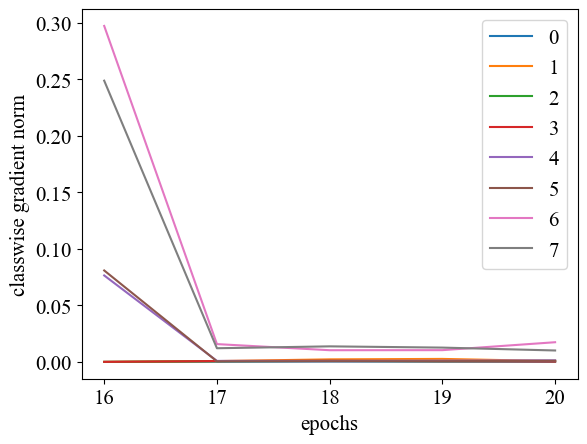

---------------------------- Task 5 -----------------------
losses=tensor([[9.2388e-04, 3.6261e-03, 1.1977e-03, 1.4859e-03, 2.4170e-03, 3.0464e-03,
         3.2496e-02, 1.1575e-01, 1.2237e+01, 1.2960e+01]])
Elapsed time(grad):105.69
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):978.896
Fairness:[ 0.03426755  0.08205692  0.07613597 -0.12284082  0.          0.
  0.10213345 -0.15066118 -0.01054642 -0.01054617]
len(updated_seq_indices)=28544
Elapsed time(etc):0.44
[21] Eval metrics for task 1 >> {'accuracy': 0.8784657916029848, 'loss': 0.0022684834950359154, 'std': 0.03254742425604601, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.7162685163865223, 'loss': 0.006780443415702498, 'std': 0.01725861539642337, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.8253678317335356, 'loss': 0.003196539339413638, 'std': 0.04734092590393907, 'EER': -1}
[21] Eval metrics for task 4 >> {'accuracy': 0.9015996766935006, 'loss': 0.001823057821029863, 'std': 

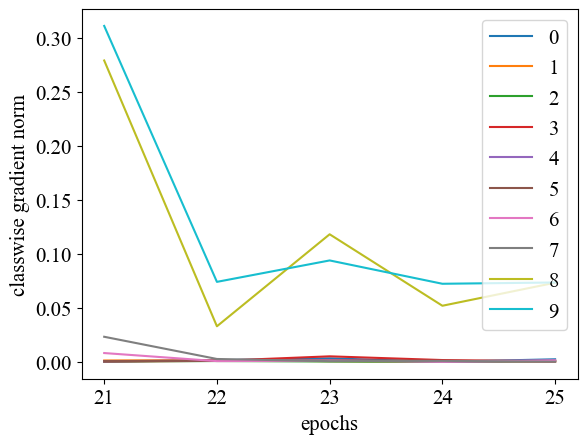

final avg-acc 0.8471174148673098
final avg-forget 0.11136285679706961


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")


656.2165	501.1123	605.2907	525.816	
2705.1559	2885.186	4567.3895	5230.8818	
2.2532	2.288	2.4708	2.339	
3378.3543	3400.5139	5184.7368	5771.287	

In [7]:
for task in range(2, 6):
    print(np.round(np.mean(list(o[task].values())), 4), end="\t")


541.0312	577.0372	913.4779	1046.1764	

In [8]:
num_class_per_task = 2
num_epochs = params['epochs_per_task']

t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = dict()
    groupwise_expected_loss[i] = dict()

for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            groupwise_true_loss[i][(task-1)*num_epochs+epoch] = tl
            groupwise_expected_loss[i][(task-1)*num_epochs+epoch] = el
            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


KeyError: 1

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][ce], end='\t')
    print()


0.0823	0.0909	0.0274	0.0047	0.0012	0.0075	0.0377	0.036	0.0156	0.0106	0.0061	0.0367	0.0204	0.0209	0.0182	0.0049	0.0264	0.0162	0.0173	0.0089	
0.0454	0.0386	0.0187	0.0096	0.0043	0.001	0.028	0.0122	0.0085	0.0061	0.0013	0.0425	0.0169	0.0201	0.0197	0.0043	0.1041	0.0455	0.0261	0.0133	
3.2447	0.9419	0.4331	0.302	0.3446	0.218	0.0615	0.0211	0.0108	0.0085	0.0048	0.0336	0.0166	0.008	0.0056	0.0039	0.0259	0.0217	0.0172	0.0094	
3.0126	0.8748	0.4113	0.3051	0.2544	0.6692	0.2001	0.1386	0.0585	0.021	0.0073	0.0616	0.0204	0.0191	0.0147	0.0153	0.1285	0.0783	0.0672	0.0458	
					3.9797	1.0527	0.3157	0.2493	0.2228	0.2891	0.1834	0.0531	0.033	0.0244	0.0891	0.2673	0.1654	0.1206	0.0939	
					4.5884	1.0513	0.4038	0.2661	0.2325	0.8348	0.2142	0.0478	0.0344	0.0261	0.07	0.1353	0.0917	0.0584	0.0317	
										4.8342	0.5295	0.212	0.1954	0.179	0.1992	0.0771	0.0408	0.0322	0.023	
										4.541	0.7119	0.3083	0.2574	0.2538	0.6047	0.334	0.2601	0.1729	0.1143	
															4.539	0.6272	0.3124	0.2244	0.2102	
															4.

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][ce], end='\t')
    print()


0.2324	0.7445	0.3458	0.1973	0.3176	0.0767	0.5549	0.476	0.2953	0.3844	-0.1302	0.1866	0.1355	0.1178	0.1052	-0.1003	-0.0028	0.1251	0.1872	0.1589	
0.0657	0.5415	0.2935	0.1973	0.1588	-0.1247	-0.0206	0.0628	0.0339	0.082	-0.1548	0.0853	0.1264	0.1165	0.1052	-0.1615	0.2538	0.3168	0.2861	0.2539	
5.9855	0.8162	0.3196	0.1973	0.1588	0.2048	0.387	0.2629	0.1633	0.1367	-0.1752	0.414	0.1581	0.1339	0.1213	-0.0523	0.0906	0.2751	0.2977	0.255	
5.8937	0.7008	0.3196	0.1973	-0.0	0.6854	0.5826	0.5129	0.4146	0.2284	-0.0688	0.1151	0.1387	0.1178	0.1052	-0.095	0.1415	0.3088	0.3066	0.255	
					7.0809	0.7426	0.0	-0.0	0.0	0.3418	0.868	0.3419	0.2928	0.2593	0.1077	0.6214	0.6266	0.5038	0.501	
					9.0311	1.0937	0.2629	0.0727	-0.0	0.6539	0.482	0.209	0.1636	0.1455	0.0901	0.4222	0.4502	0.3951	0.2955	
										9.7394	0.1773	0.0	0.0	0.0	0.1409	0.3436	0.3262	0.3056	0.248	
										8.4072	0.4152	-0.0	-0.0	-0.0	0.5594	0.8191	0.7067	0.5792	0.5831	
															9.5008	0.6323	-0.0	0.0	-0.0	
															9.1742	0.505	0.099	0.

In [ ]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9155131671428458
EER:0.035558595517968014
std:0.04829100301640192
